In [39]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Load data
excel_data = pd.read_excel('historical_prices.xlsx', sheet_name=None)
combined_data = pd.DataFrame()

# Combine data from all stocks
for sheet_name, df in excel_data.items():
    df['Stock'] = sheet_name
    combined_data = pd.concat([combined_data, df], ignore_index=True)

# Scale only the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['Close']])  # Only scaling 'Close'

# Prepare one-hot encoding for stock identifiers
one_hot_stocks = pd.get_dummies(combined_data['Stock'])

# Preparing sequences of closing prices with one-hot encoding for LSTM model
sequence_length = 60
x_train, y_train = [], []

for i in range(sequence_length, len(scaled_data)):
    # Use only 'Close' price
    close_sequence = scaled_data[i-sequence_length:i, 0].reshape(-1, 1)
    
    # Repeat the one-hot encoded stock identifier across the sequence length
    stock_name = combined_data['Stock'].iloc[i]
    stock_one_hot = one_hot_stocks.loc[i-sequence_length:i-1].to_numpy()  # Ensure it matches the sequence length
    
    # Combine closing price data with one-hot encoded stock identifiers
    x_input = np.hstack([close_sequence, stock_one_hot])
    x_train.append(x_input)
    y_train.append(scaled_data[i, 0])  # Target is the 'Close' price

x_train, y_train = np.array(x_train), np.array(y_train)

# Confirm the shapes
print(f"x_train shape: {x_train.shape}")  # Should be (samples, time steps, features)
print(f"y_train shape: {y_train.shape}")  # Should be (samples,)

# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=10)

# Save the model
model.save('stock_model.h5')

x_train shape: (5830, 60, 6)
y_train shape: (5830,)
Epoch 1/10


/Users/brianerichsenfagundes/Desktop/6017/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5830/5830 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0051
Epoch 2/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0023
Epoch 3/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0019
Epoch 4/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0015
Epoch 5/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 307s 53ms/step - loss: 0.0013
Epoch 6/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 0.0012
Epoch 7/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0011
Epoch 8/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0012
Epoch 9/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 178s 30ms/step - loss: 9.7445e-04
Epoch 10/10
5830/5830 ━━━━━━━━━━━━━━━━━━━━ 899s 154ms/step - loss: 0.0012


In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

def predict_next_day(stock_data, model, scaler, sequence_length=60):
    # 1. Prepare the input sequence for prediction (last 60 days of stock data)
    last_60_days = stock_data.tail(sequence_length)
    
    # Scale only the 'Close' feature for prediction
    last_60_days_scaled = scaler.transform(last_60_days[['Close']])  # Use only 'Close'

    # 2. One-hot encode the stock identifier
    stock_name = last_60_days['Stock'].iloc[0]
    stock_one_hot = pd.get_dummies([stock_name])
    
    # Match the expected number of columns from training; fill missing columns if necessary
    expected_columns = model.input_shape[-1] - last_60_days_scaled.shape[1]  # Only 'Close' is used, not Volume
    stock_one_hot = stock_one_hot.reindex(columns=range(expected_columns), fill_value=0).values[0]

    # 3. Combine the scaled data with one-hot encoded stock identifier
    x_input = np.hstack([last_60_days_scaled, np.tile(stock_one_hot, (sequence_length, 1))])
    x_input = np.reshape(x_input, (1, x_input.shape[0], x_input.shape[1]))

    # 4. Predict the next day price
    predicted_stock_price = model.predict(x_input)
    predicted_price = scaler.inverse_transform([[predicted_stock_price[0][0], 0]])[0][0]  # Only inverse transform the 'Close' value

    return predicted_price

# Load the updated model
model = load_model('stock_model.h5')

# Example prediction for a specific stock
predicted_price = predict_next_day(combined_data[combined_data['Stock'] == 'S&P 500'], model, scaler)
print(f'Predicted next day price for GOOG: {predicted_price:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted next day price for GOOG: 7376.49


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

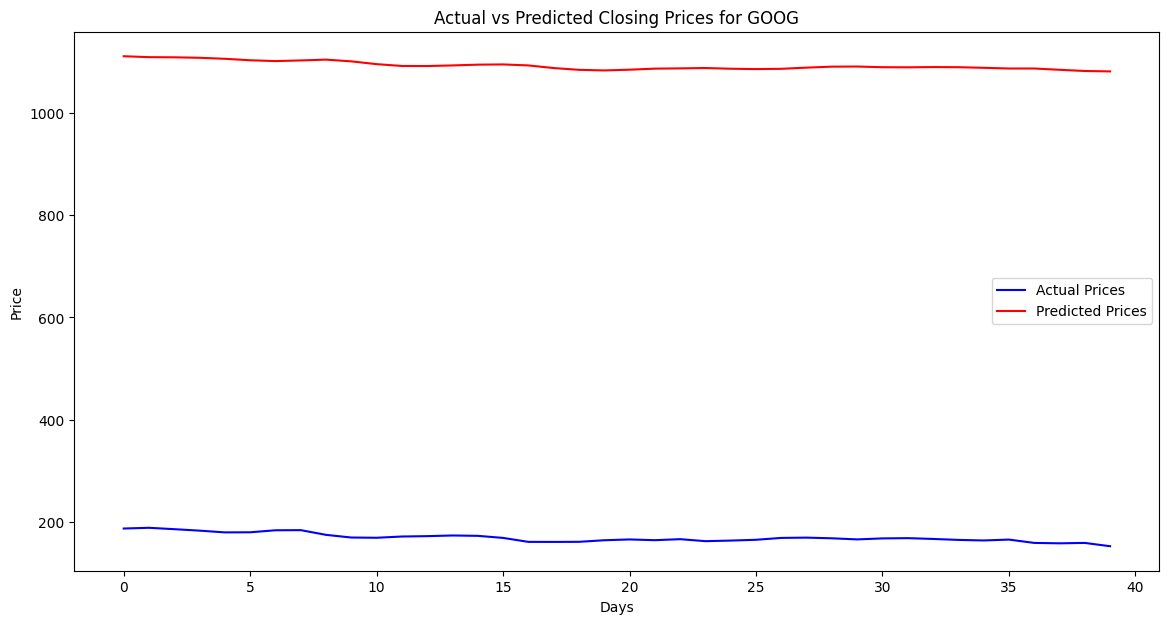

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Example testing data (e.g., the last 100 days to compare predictions with actuals)
test_stock = 'GOOG'
test_data = combined_data[combined_data['Stock'] == test_stock].tail(100)  # Use last 100 days for testing

# Prepare actual and predicted prices for comparison
actual_prices = test_data['Close'].values  # Using last 40 days of actual data for comparison
predicted_prices = []

# Rolling prediction for each day based on the previous 60 days of data
for i in range(len(actual_prices) - sequence_length):
    subset = test_data.iloc[i:i + sequence_length]  # Subset to match the required input shape
    predicted_price = predict_next_day(subset, model, scaler)
    predicted_prices.append(predicted_price)

# Calculate evaluation metrics
mae = mean_absolute_error(actual_prices[-len(predicted_prices):], predicted_prices)
mse = mean_squared_error(actual_prices[-len(predicted_prices):], predicted_prices)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(actual_prices[-len(predicted_prices):], label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title(f'Actual vs Predicted Closing Prices for {test_stock}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
